![](Python专栏课.jpg)

以往对比两个文本数据差异，比较简单的技术实现方法是生成两文个词云图，但是词云图无法直观显示词语层面的权重。

**Shifterator**包提供了构建词移图的功能，垂直条形图可以量化哪些词会导致**两个文本**之间的成对差异以及它们如何起作用。 通过允许您查看单词使用方式的变化，单词转换可帮助您对情绪、熵和分歧进行分析，这些分析从根本上来说更具可解释性。

Shifterator亮点：
- 提供可解释的工具，用于将文本作为数据处理并映射出两个文本相似性或差异性
- 实现常见的文本比较度量，包括相对频率、香农熵、Tsallis熵、Kullback-Leibler散度和 Jensen-Shannon 散度。
- 基于字典的情绪分析方法计算的加权平均值。
- 在研究初期可用于诊断数据、感知测量误差。

计算社会科学家、数字人文主义者和其他文本分析从业者都可以使用 Shifterator 从文本数据构建可靠、稳健和可解释的故事。

## 安装

In [ ]:
!pip3 install shifterator==0.2.2

## 导入数据
准备的外卖csv数据，含label和review两个字段。

其中label是好评差评的标注，
- 0为差评， 
- 1为好评

In [1]:
import pandas as pd

reviews_df = pd.read_csv("data/WaiMai8k.csv", encoding='utf-8')
reviews_df.head()

,label,review
0,0,差评，11点14订餐，13点20饭才到，2个小时才把我的午饭送到，而且还是打了2次客服电话，...
1,0,我让多加汁也没加，怎么吃啊？干了吧唧的
2,0,慢，多远的距离，那么长时间
3,0,盒子很精致，味道还好。整体不错
4,0,餐呢？就为了不半价，餐没送来就确认了？必须投诉


有个疑问，外卖好差评中的用词有什么差异(区别/特点)？

## 准备两组文本数据
shifterator需要两组文本数据，格式为长度相同的词频统计字典。

按照label类别，将数据整理为两个文本数据。在准备的过程中，我们需要做一些清洗操作
- 清除非中文字符，如网址、邮箱、标点符号
- 清除信息量比较低的停用词

In [2]:
import collections
import jieba
import re 

texts_neg = reviews_df[reviews_df['label']==0]['review'].tolist()
texts_pos = reviews_df[reviews_df['label']==1]['review'].tolist()


def clean_text(docs):
    """清洗文本中的非中文字符、停用词，返回词频统计结果
    docs : 待处理的文档列表
    """
    stop_words = open('data/stopwords.txt', encoding='utf-8').read().split('\n')
    text = "".join(docs)
    text = "".join(re.findall("[\u4e00-\u9fa5]+", text))
    words = jieba.lcut(text)
    words = [w for w in words if w not in stop_words]
    wordfreq_dict = collections.Counter(words)
    return wordfreq_dict


clean_texts_neg = clean_text(texts_neg)
clean_texts_pos = clean_text(texts_pos)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/sc/3mnt5tgs419_hk7s16gq61p80000gn/T/jieba.cache
Loading model cost 0.673 seconds.
Prefix dict has been built successfully.


## 无聊的传统绘图
使用条形图、词云图绘制，为了缩小代码量，这里只绘制差评数据。需要注意的是matplotlib不显示中文，这里需要先使用下面三行代码获取电脑中自带的中文字体列表mpl_fonts， 

```python
from matplotlib.font_manager import FontManager
 
mpl_fonts = set(f.name for f in FontManager().ttflist)
print(mpl_fonts)
```

经过运行，我的电脑mpl_fonts里有**Arial Unicode MS** ，后面用matplotlib显示中文的地方，我都使用该字体。

In [4]:
#准备DataFrame数据
common_neg = pd.DataFrame(clean_texts_neg.most_common(15),
                             columns=['words', 'count'])

common_pos = pd.DataFrame(clean_texts_pos.most_common(15),
                             columns=['words', 'count'])

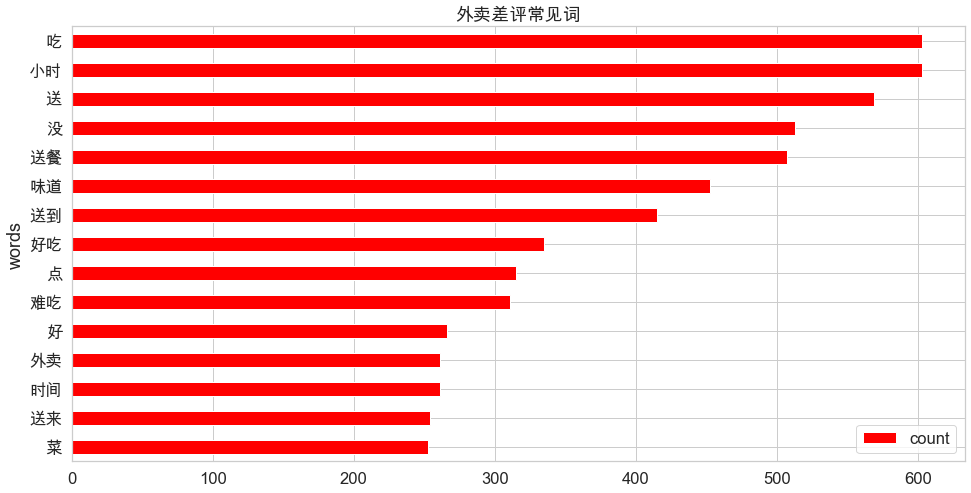

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

#为了显示中文
matplotlib.rc("font", family='Arial Unicode MS')


fig, ax = plt.subplots(figsize=(16, 8))

#绘制水平条形图
common_neg.sort_values(by='count').plot.barh(x='words',
                     y='count',
                      ax=ax,
                      color="red")

ax.set_title("外卖差评常见词")
plt.show()

绘制词云图，这里使用的pyecharts包。由于该包作者更新强度比较大，为了保证日后本教程仍可正常运行，这里提供当前我使用的pyecharts相关的版本，大家可以运行下面代码保证运行出正确结果

In [ ]:
!pip3 install pyecharts==1.6.2
!pip3 install pyecharts-javascripthon==0.0.6
!pip3 install pyecharts-jupyter-installer==0.0.3
!pip3 install pyecharts-snapshot==0.2.0

In [6]:
import pyecharts.options as opts
from pyecharts.charts import WordCloud
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK

wordfreqs = [(w, str(f)) for w,f in dict(clean_texts_neg).items()]


wc = WordCloud()
wc.add(series_name="", data_pair=wordfreqs, word_size_range=[20, 100])
wc.set_global_opts(title_opts=opts.TitleOpts(title="外卖差评词云图", 
                                             title_textstyle_opts=opts.TextStyleOpts(font_size=23)),
                   tooltip_opts=opts.TooltipOpts(is_show=True))
wc.load_javascript()
wc.render_notebook()

## 使用Shifterator绘制词移图
终于要用到 **Shifterator** 包了！ 我们可以使用这个包根据频率和情绪（或其他值）比较负面和正面的外卖评论，这里我只计算了频率作为权重


### 熵移图Entropy shift

第一幅图是entropy shift graph

具体信息请查看文档  https://github.com/ryanjgallagher/shifterator

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


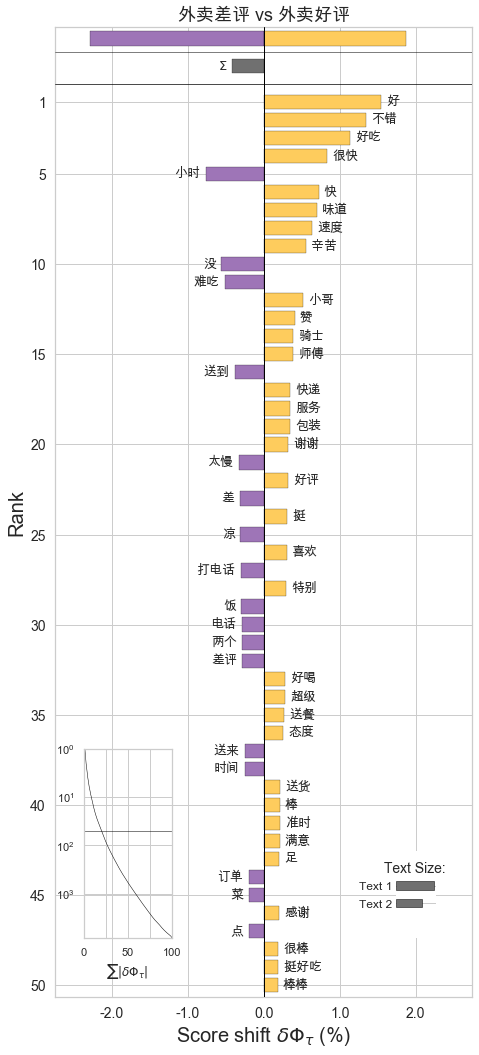

<AxesSubplot:title={'center':'外卖差评 vs 外卖好评'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [7]:
from shifterator import EntropyShift
import matplotlib
matplotlib.rc("font", family='Arial Unicode MS')

entropy_shift = EntropyShift(type2freq_1=clean_texts_neg,
                             type2freq_2=clean_texts_pos,
                             base=2)
entropy_shift.get_shift_graph(title='外卖差评 vs 外卖好评')

看起来最能决定外卖差评的用语是配送时间，其次才是口味。

最能决定外卖好评的似乎是口味，其次才是配送时间。

通过Shifterator我们能够看出不同词在不同文本中的作用程度。需要注意的是，我们只使用了最高的前15词频，所以显示的词有些少

## 总结
希望本文能对你的研究有帮助，代码撰写调试不易，希望帮忙转载

